In [4]:
import dask.dataframe as dd
import dask.multiprocessing
import os
path = "./data/"

In [5]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [6]:



mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH'] 


import xgboost as xgb


In [7]:
plt.style.use('fivethirtyeight')

In [8]:
bureau_balance = pd.read_csv(path+ "bureau_balance.csv")
bureau = pd.read_csv(path+ "bureau.csv")

In [9]:
application_test = pd.read_csv("./data/application_test.csv")
application_train = pd.read_csv("./data/application_train.csv")

In [6]:
application_test.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

In [7]:
application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [10]:
bureau_balance.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

In [9]:
bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [11]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [18]:
missing_values = missing_values_table(bureau)
missing_values.head(20)

Your selected dataframe has 15 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


In [12]:
del bureau['AMT_ANNUITY']
del bureau['AMT_CREDIT_MAX_OVERDUE']

In [13]:
bureau.DAYS_ENDDATE_FACT[bureau.DAYS_ENDDATE_FACT.isnull()] = bureau.DAYS_ENDDATE_FACT.mean()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
bureau.DAYS_ENDDATE_FACT.mean()

-1017.4371480764103

In [15]:
bureau[bureau.AMT_CREDIT_SUM.isnull()]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
218508,405791,6008179,Active,currency 1,0,0,NaN,-1017.437148,0,NaN,654993.0,NaN,0.0,Another type of loan,-5
314570,418331,6064357,Active,currency 1,0,0,NaN,-1017.437148,0,NaN,2250000.0,NaN,0.0,Another type of loan,-16
572703,367465,6299480,Active,currency 1,0,0,388.0,-1017.437148,0,NaN,1204582.5,NaN,0.0,Another type of loan,-5
585311,371162,6452468,Closed,currency 1,0,0,NaN,-111.000000,0,NaN,0.0,NaN,0.0,Another type of loan,-64
590328,209921,5491946,Closed,currency 1,-5,0,NaN,-46.000000,0,NaN,0.0,NaN,0.0,Another type of loan,-36
814128,425959,6388671,Active,currency 1,0,0,NaN,-1017.437148,0,NaN,185926.5,NaN,0.0,Another type of loan,-3
987620,375588,5078559,Active,currency 1,0,0,NaN,-1017.437148,0,NaN,1309572.0,NaN,0.0,Another type of loan,-39
1055762,118044,6753699,Active,currency 1,-422,0,643.0,-1017.437148,0,NaN,0.0,NaN,0.0,Consumer credit,-29
1113131,139064,6121986,Closed,currency 1,0,0,NaN,-72.000000,0,NaN,0.0,NaN,0.0,Another type of loan,-23
1172368,207533,5875729,Closed,currency 1,0,0,NaN,-441.000000,0,NaN,0.0,NaN,0.0,Another type of loan,-77


In [20]:
bureau.AMT_CREDIT_SUM_LIMIT[bureau.AMT_CREDIT_SUM_LIMIT.isnull()] = bureau.AMT_CREDIT_SUM_LIMIT.mean()
bureau.AMT_CREDIT_SUM_DEBT[bureau.AMT_CREDIT_SUM_DEBT.isnull()] = bureau.AMT_CREDIT_SUM_DEBT.mean()
bureau.DAYS_CREDIT_ENDDATE[bureau.DAYS_CREDIT_ENDDATE.isnull()] = bureau.DAYS_CREDIT_ENDDATE.mean()
bureau.AMT_CREDIT_SUM[bureau.AMT_CREDIT_SUM.isnull()] = bureau.AMT_CREDIT_SUM.mean()

# DAYS_ENDDATE_FACT	633653	36.9
# AMT_CREDIT_SUM_LIMIT	591780	34.5
# AMT_CREDIT_SUM_DEBT	257669	15.0
# DAYS_CREDIT_ENDDATE	105553	6.1
# AMT_CREDIT_SUM

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anac

In [23]:
bureau = pd.get_dummies(bureau)

In [24]:
bureau.columns.values

array(['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan',
       'CREDIT_TYPE_Cash loan (non-earmarked)',
       'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Credit card',
       'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
       'CREDIT_TYPE_Loan for the purchase of equipment',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microl

In [25]:
maen_cols = ['SK_ID_CURR','DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_SUM', \
             'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'DAYS_CREDIT_UPDATE',  ]
sum_cols = [ 'SK_ID_CURR','CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_OVERDUE', 
         'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan',
        'CREDIT_TYPE_Interbank credit', 'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
       'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for the purchase of equipment',  'CREDIT_TYPE_Mobile operator loan',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mortgage',
       'CREDIT_TYPE_Real estate loan', 'CREDIT_TYPE_Unknown type of loan']



In [26]:
b1 = bureau[maen_cols].groupby('SK_ID_CURR').mean()
b2 = bureau[sum_cols].groupby('SK_ID_CURR').sum()
b1.reset_index(inplace = True)
b2.reset_index(inplace = True)

In [27]:
bureau_df= pd.merge(b1,b2, on='SK_ID_CURR')

In [28]:
cols = ['SK_ID_CURR']
bureau_train = pd.merge(bureau_df, application_train[cols], on = 'SK_ID_CURR', how = 'inner')
bureau_test = pd.merge(bureau_df, application_test[cols], on = 'SK_ID_CURR', how ='inner')

In [29]:
len(bureau_df), len(bureau_train), len(bureau_test)

(305811, 263491, 42320)

In [31]:
bureau_train.to_csv('bureau_train.csv')
bureau_test.to_csv('bureau_test.csv')

In [143]:

model_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=2)
model_xgb.fit(df.iloc[:,1:-1], df.TARGET)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [144]:
model_xgb.feature_importances_

array([0.19463088, 0.03355705, 0.09060403, 0.05369128, 0.1442953 ,
       0.1375839 , 0.03355705, 0.03020134, 0.        , 0.06040268,
       0.01677852, 0.0704698 , 0.02684564, 0.        , 0.        ,
       0.        , 0.        , 0.00671141, 0.        , 0.01006711,
       0.03691275, 0.        , 0.        , 0.        , 0.03691275,
       0.01677852, 0.        ], dtype=float32)

In [28]:
model_xgb.

<bound method XGBModel.apply of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>

In [12]:
missing_values_bureau_balance = missing_values_table(bureau_balance)
missing_values_bureau_balance.head(20)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [14]:
bureau_balance = pd.merge(bureau_balance, bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], how='left',  on = 'SK_ID_BUREAU')

In [15]:
bureau_balance = bureau_balance[bureau_balance.SK_ID_CURR.notnull()]

In [21]:
bureau_balance.SK_ID_CURR = bureau_balance.SK_ID_CURR.astype(int)

In [24]:
bureau_balance.head(20)

,SK_ID_BUREAU,MONTHS_BALANCE,SK_ID_CURR,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,380361,0,0,0,0,0,0,1,0
1,5715448,-1,380361,0,0,0,0,0,0,1,0
2,5715448,-2,380361,0,0,0,0,0,0,1,0
3,5715448,-3,380361,0,0,0,0,0,0,1,0
4,5715448,-4,380361,0,0,0,0,0,0,1,0
5,5715448,-5,380361,0,0,0,0,0,0,1,0
6,5715448,-6,380361,0,0,0,0,0,0,1,0
7,5715448,-7,380361,0,0,0,0,0,0,1,0
8,5715448,-8,380361,0,0,0,0,0,0,1,0
9,5715448,-9,380361,1,0,0,0,0,0,0,0


In [23]:
bureau_balance = pd.get_dummies(bureau_balance)

In [25]:
cols_to_maens = ['SK_ID_CURR', 'MONTHS_BALANCE']
bb1 = bureau_balance[cols_to_maens].groupby('SK_ID_CURR').mean()

# df2.data1.groupby(df2.key1).sum()
cols_to_mode = ['SK_ID_CURR','STATUS_0', 'STATUS_1',
       'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X']
bb2 = bureau_balance[cols_to_mode].groupby('SK_ID_CURR').sum()

In [26]:
bb1.shape, bb2.shape

((134542, 1), (134542, 8))

In [27]:
bureau_balance_df = pd.concat( [bb1, bb2] , axis = 1)
bureau_balance_df.reset_index(inplace = True)

In [28]:
bureau_balance_df.head()

,SK_ID_CURR,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,100001,-16.279070,31.0,1.0,0.0,0.0,0.0,0.0,110.0,30.0
1,100002,-24.554545,45.0,27.0,0.0,0.0,0.0,0.0,23.0,15.0
2,100005,-4.333333,14.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
3,100010,-46.000000,20.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0
4,100013,-29.373913,79.0,7.0,0.0,0.0,0.0,0.0,103.0,41.0


In [29]:
cols = ['SK_ID_CURR']
bureau_balance_train = pd.merge(bureau_balance_df, application_train[cols], on = 'SK_ID_CURR', how = 'inner')
bureau_balance_test = pd.merge(bureau_balance_df, application_test[cols], on = 'SK_ID_CURR', how = 'inner')

In [30]:
len(bureau_balance_train), len(bureau_balance_test), len(bureau_balance_df)

(92231, 42311, 134542)

In [31]:
bureau_balance_train.to_csv('bureau_balance_train.csv')
bureau_balance_test.to_csv('bureau_balance_test.csv')

In [32]:

model_xgb_2 = xgb.XGBClassifier(n_estimators=100, max_depth=3)
model_xgb_2.fit(df2.iloc[:,1:-1], df2.TARGET)

NameError: name 'xgb' is not defined

In [113]:
model_xgb_2.feature_importances_

array([0.32302406, 0.18213059, 0.16151203, 0.        , 0.        ,
       0.0137457 , 0.07216495, 0.11340206, 0.13402061], dtype=float32)

In [ ]:
param_range = np.logspace(-6, -1, 10)

In [146]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


<IPython.core.display.Javascript object>


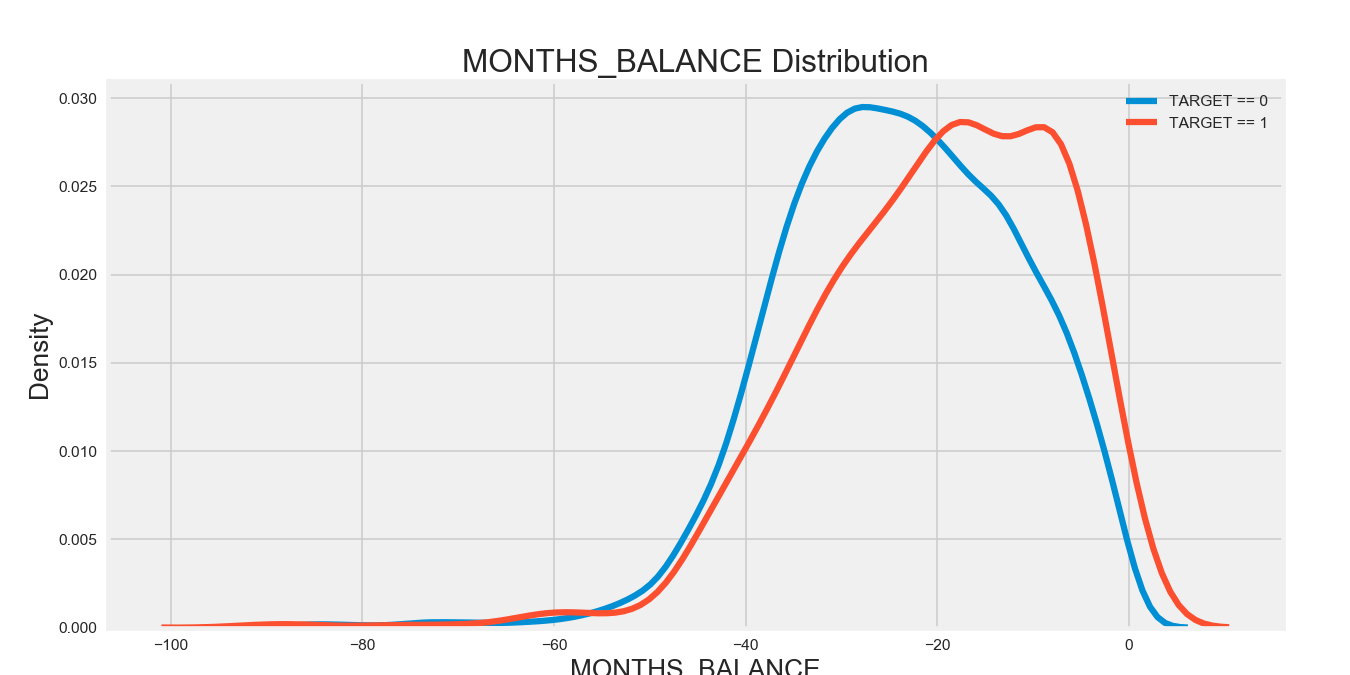

The correlation between MONTHS_BALANCE and the TARGET is 0.0823
Median value for loan that was not repaid = -18.5000
Median value for loan that was repaid =     -23.8342


In [147]:
kde_target('MONTHS_BALANCE', df2)